In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data sources
import yfinance as yf
from fredapi import Fred

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pd.options.display.max_rows = 500
%matplotlib inline 

# Gather Data

In [2]:
api_key = 'b27994ea92311f213e0e709cdd98849b' # hidden
fred = Fred(api_key)

In [3]:
# Set period
start = datetime(1999, 1, 1)
end = date.today() # '2024-06-02'

# Gather series
vix = fred.get_series('VIXCLS', start, end)
vix_lag_1month = vix.shift(21)
interest_rates = fred.get_series('FEDFUNDS', start, end)
gdp = fred.get_series('GDP', start, end)
gdp_growth = gdp.pct_change() * 100
cpi = fred.get_series('CPIAUCSL', start, end)
unemployment = fred.get_series('UNRATE', start, end)
housing_starts = fred.get_series('HOUST', start, end)
home_prices = fred.get_series('CSUSHPINSA', start, end)
usd_idx = yf.download('DX-Y.NYB', start, end)['Adj Close']
corporate_bond_yields = fred.get_series('BAMLC0A4CBBBEY', start, end)
treasury_yields = fred.get_series('DGS10', start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Gather S&P500 Data
sp500 = yf.download('^GSPC', start=start, end=end)
sp500['Returns'] = sp500['Adj Close'].pct_change()
volatility = sp500['Returns'].rolling(window=21).std() * (np.sqrt(252))  # Annualized volatility

[*********************100%***********************]  1 of 1 completed


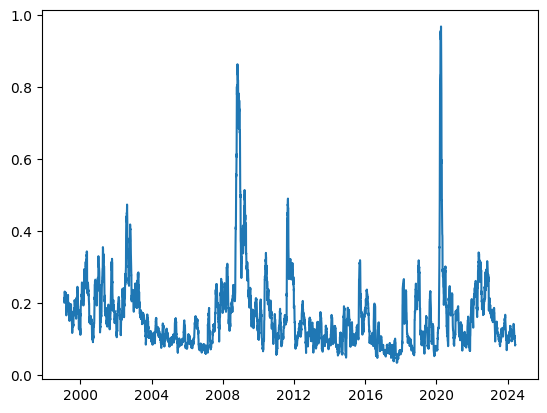

In [5]:
plt.plot(volatility)

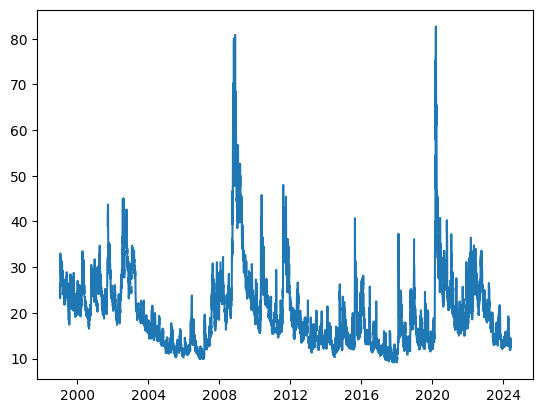

In [6]:
plt.plot(vix)

In [7]:
# Combine all macro series into one dataframe
combined_df = pd.concat([
    volatility,
    vix,
    vix_lag_1month,
    interest_rates,
    gdp,
    gdp_growth,
    cpi,
    unemployment,
    housing_starts,
    home_prices,
    usd_idx,
    corporate_bond_yields,
    treasury_yields
], axis=1)

# Set columns
combined_df.columns = [
    'Volatility',
    'VIX', 
    'VIX_Lag_One_Month',
    'Interest_Rates', 
    'GDP', 
    'GDP_Growth',
    'CPI', 
    'Unemployment_Rate', 
    'Housing_Starts', 
    'Home_Prices', 
    'US_Dollar_Index', 
    'Corporate_Bond_Yields', 
    'Ten_Year_Treasury_Yield'
]

combined_df = sm.add_constant(combined_df)

In [8]:
# Let's view our dataset
combined_df

,const,Volatility,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
1999-01-01,1.0,NaN,NaN,NaN,4.63,9411.682,NaN,164.7,4.3,1748.0,92.714,94.169998,NaN,NaN
1999-01-04,1.0,NaN,26.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.440002,6.72,4.69
1999-01-05,1.0,NaN,24.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.470001,6.78,4.74
1999-01-06,1.0,NaN,23.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.529999,6.75,4.73
1999-01-07,1.0,NaN,24.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.720001,6.80,4.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,1.0,0.093527,12.92,14.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.669998,5.75,4.51
2024-06-03,1.0,0.090347,13.11,13.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.139999,5.67,4.41
2024-06-04,1.0,0.081841,13.16,13.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.110001,5.62,4.33
2024-06-05,1.0,0.084046,12.63,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.269997,5.59,4.29


In [34]:
# Forward Fill imputation
combined_df.fillna(method='ffill', inplace=True)
# Let's select from 2000 onwards
combined_df = combined_df[combined_df.index.get_loc('2000-01-01'):]
# Let's view our dataframe
combined_df.tail(20)

,Volatility,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2024-05-10,0.135918,12.55,14.91,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.309998,5.78,4.50
2024-05-13,0.124874,13.60,17.31,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.220001,5.77,4.48
2024-05-14,0.116194,13.42,19.23,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.010002,5.73,4.45
2024-05-15,0.120255,12.45,18.40,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.349998,5.63,4.36
2024-05-16,0.117744,12.42,18.21,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.459999,5.66,4.38
2024-05-17,0.116595,11.99,18.00,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.449997,5.69,4.42
2024-05-20,0.109166,12.15,18.71,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.570000,5.70,4.44
2024-05-21,0.107297,11.86,16.94,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.660004,5.68,4.41
2024-05-22,0.103640,12.29,15.69,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.940002,5.70,4.43
2024-05-23,0.108683,12.77,15.97,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.110001,5.75,4.47


# Plot data

Text(0.5, 1.0, 'US GDP from 2000-2024 in billions')

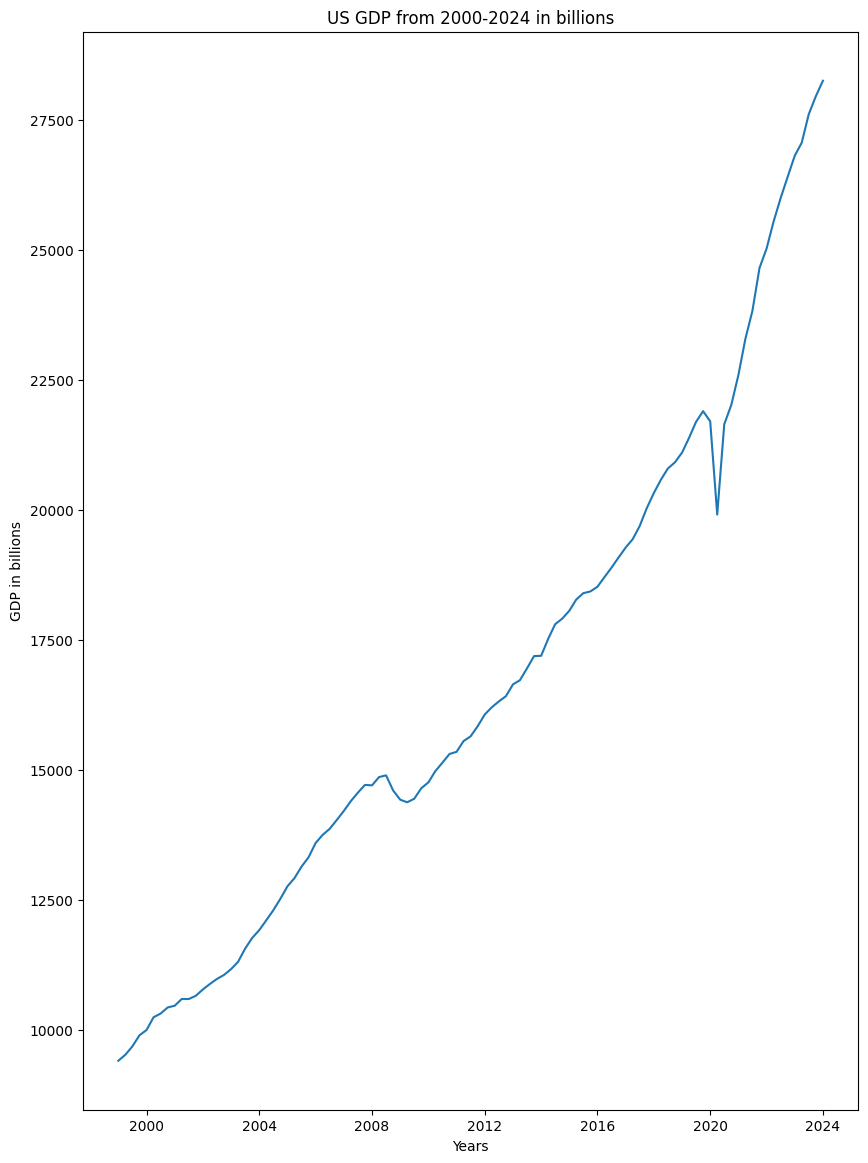

In [35]:
plt.figure(figsize=(10,14))
plt.plot(gdp, data=combined_df)
plt.xlabel('Years')
plt.ylabel('GDP in billions')
plt.title('US GDP from 2000-2024 in billions')

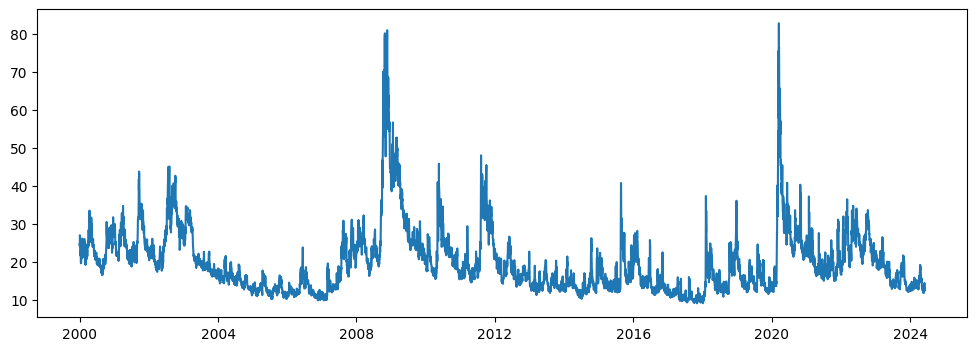

In [36]:
plt.figure(figsize=(12,4))
plt.plot(combined_df['VIX'])

In [37]:
combined_df[combined_df.isna().any(axis=1)].empty
# There are no NANs in our dataframe

True

# Regression

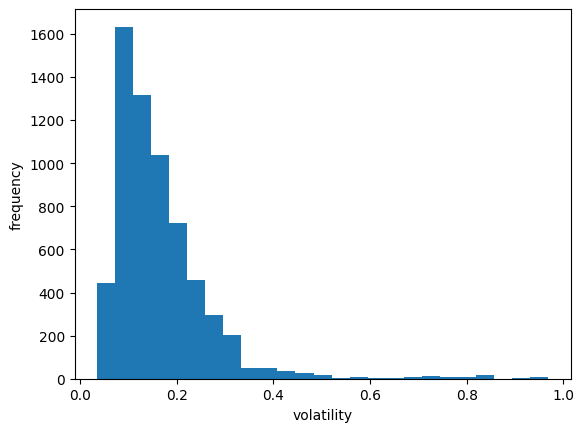

In [38]:
# Histogram of response
plt.hist(volatility, bins=25)
plt.ylabel('frequency')
plt.xlabel('volatility')
plt.show()
# sns.kdeplot(vix)

(array([  33.,  280., 1030., 1529., 1540., 1178.,  555.,  136.,   34.,
          62.]),
 array([-3.36021889, -3.02741349, -2.69460808, -2.36180268, -2.02899728,
        -1.69619188, -1.36338647, -1.03058107, -0.69777567, -0.36497027,
        -0.03216486]),
 <BarContainer object of 10 artists>)

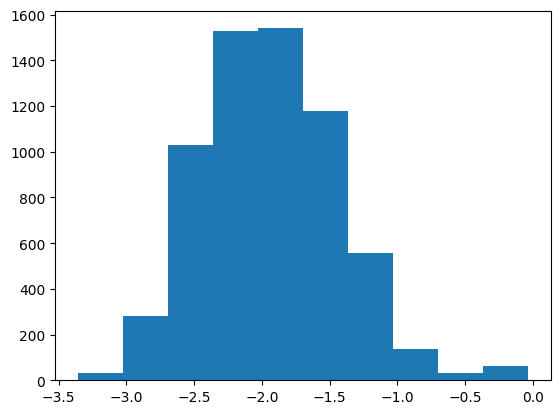

In [39]:
# Log transform?
plt.hist(np.log(volatility))

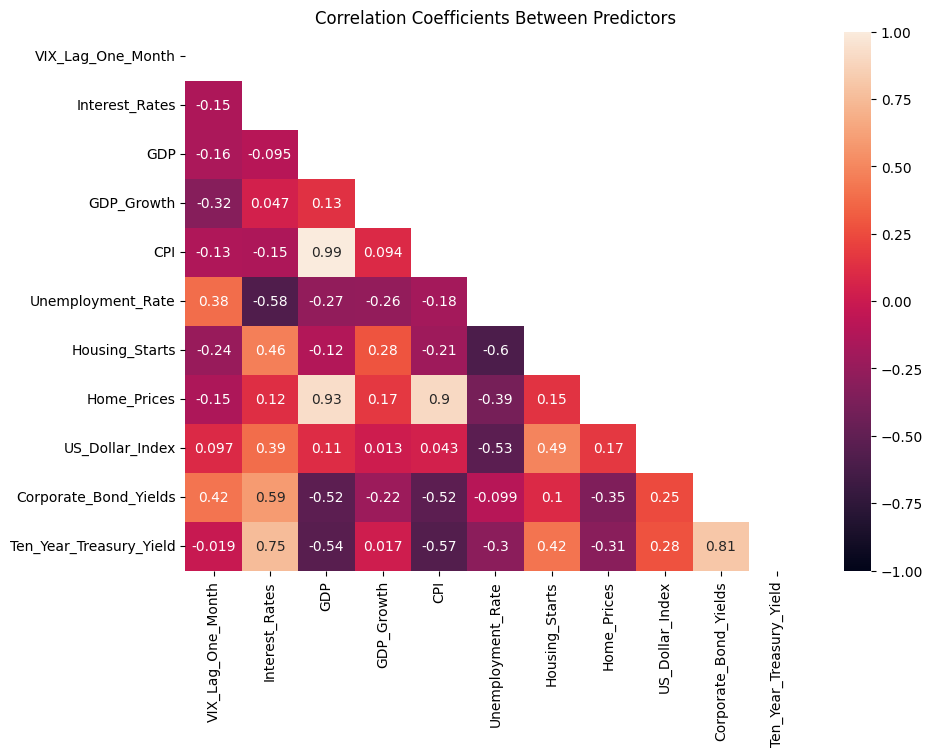

In [40]:
# Test for multicollinearity
plt.figure(figsize=(10,7))

predictors = combined_df.drop(columns=["VIX", 'Volatility'])
mask = np.triu(np.ones_like(predictors.corr(), dtype=bool))
sns.heatmap(predictors.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients Between Predictors')
plt.show()

In [41]:
# Test for homoskedasticity


In [42]:
# Fit the multivariable regression model
model = smf.ols(formula = 'VIX ~ VIX_Lag_One_Month + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     1232.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:23:17   Log-Likelihood:                -19601.
No. Observations:                6538   AIC:                         3.923e+04
Df Residuals:                    6526   BIC:                         3.931e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [43]:
# ANOVA
anova_result = sm.stats.anova_lm(model, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
VIX_Lag_One_Month,19432.648154,1.0,824.516564,7.367883e-171
Interest_Rates,2556.194096,1.0,108.457908,3.358799e-25
GDP,0.119159,1.0,0.005056,9.433168e-01
GDP_Growth,11.882575,1.0,0.504171,4.776985e-01
CPI,126.713093,1.0,5.376367,2.044208e-02
Unemployment_Rate,705.874716,1.0,29.949876,4.598497e-08
Housing_Starts,11.177598,1.0,0.474259,4.910587e-01
Home_Prices,908.642475,1.0,38.553200,5.655513e-10
US_Dollar_Index,1217.279141,1.0,51.648484,7.377254e-13
Corporate_Bond_Yields,27762.218768,1.0,1177.935660,1.786684e-237


# Plots

Text(0, 0.5, '$Bn')

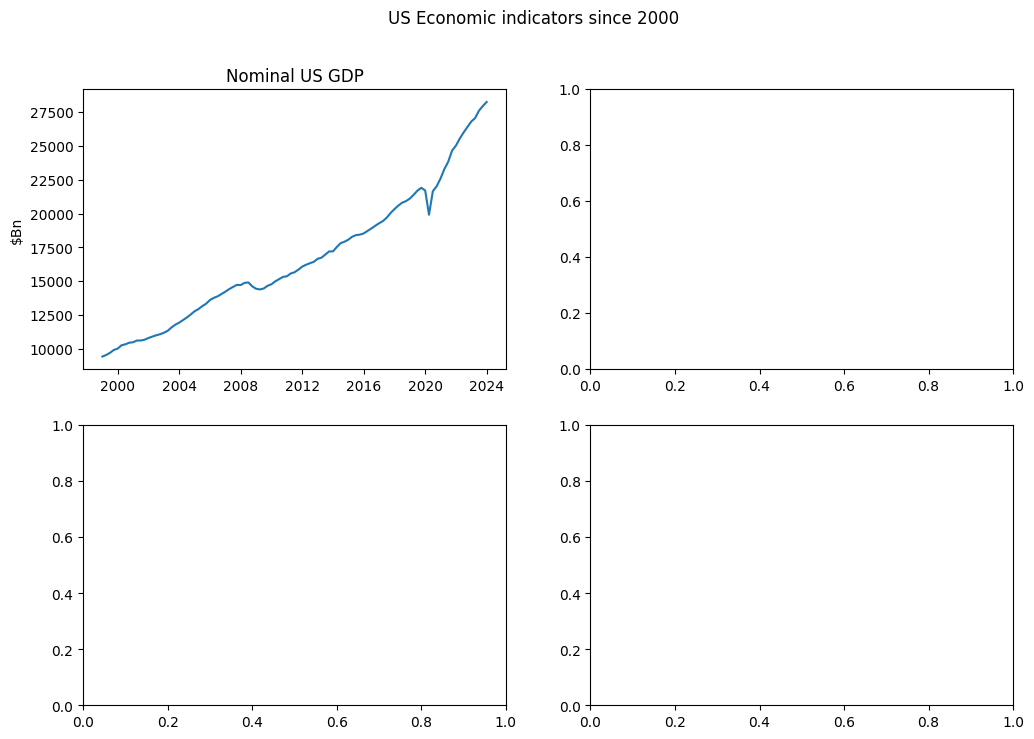

In [44]:
fig, axs  = plt.subplots(2, 2,figsize=(12, 8))
fig.suptitle('US Economic indicators since 2000')

axs[0][0].plot(gdp)
axs[0][0].set_title("Nominal US GDP")
axs[0,0].set_ylabel("$Bn")

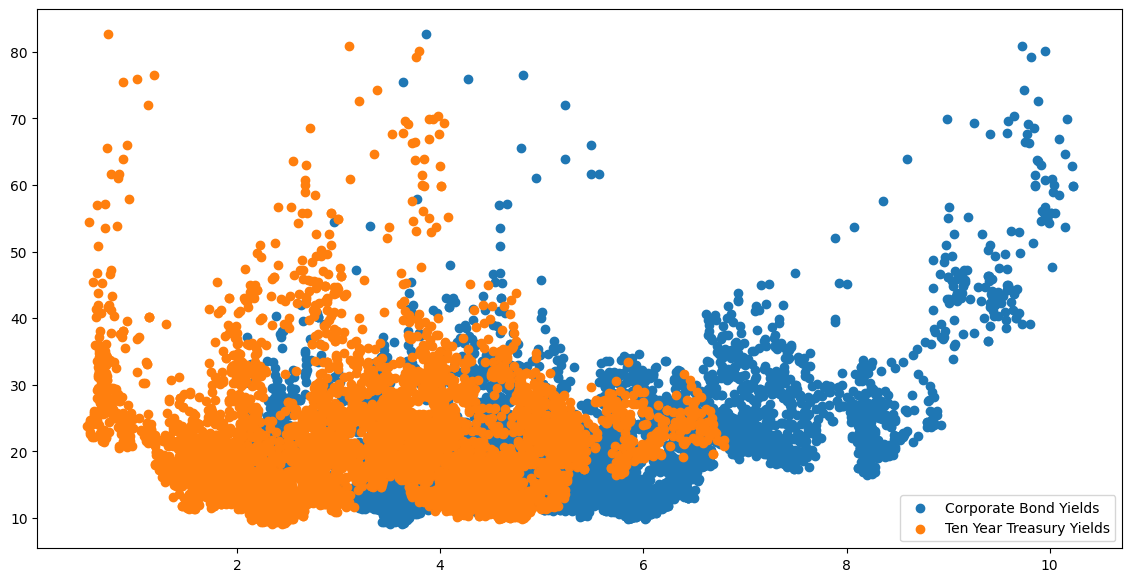

In [45]:
plt.figure(figsize=(14,7))
plt.scatter("Corporate_Bond_Yields", "VIX", label='Corporate Bond Yields', data=combined_df)
plt.scatter("Ten_Year_Treasury_Yield", "VIX", label='Ten Year Treasury Yields', data=combined_df)
plt.legend()

In [46]:
# Extract residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues

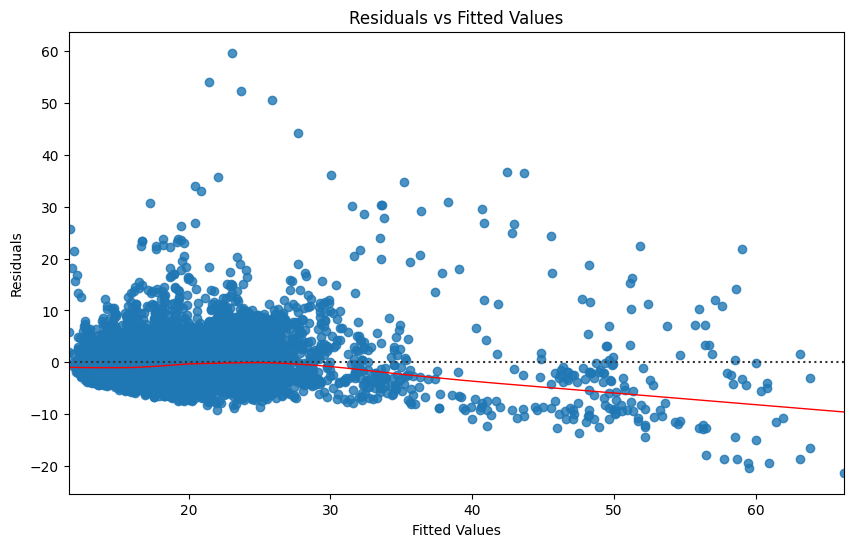

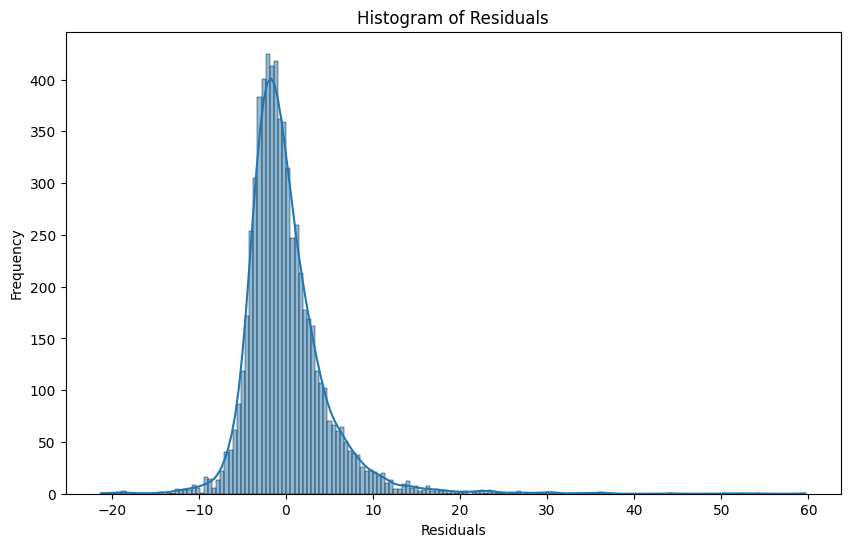

In [51]:
# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

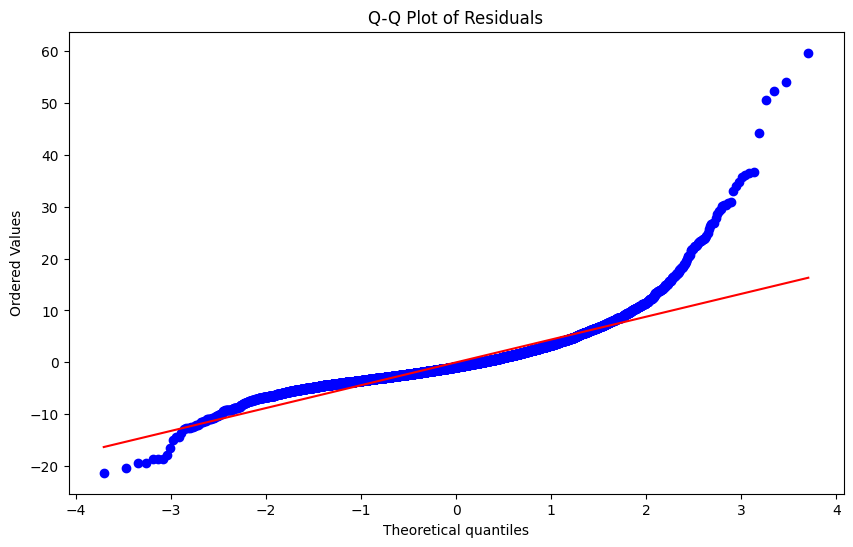

In [50]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()